In [50]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import RebapFunctions as fnc
import datetime as dt
import DBFunctions as db
%matplotlib inline

In [51]:
NRV = db.GetNRVSaldo()
ID = db.GetIDPrices()
IDnew = pd.read_csv(db.datapath+'\\EEX_Daten\\151212_ID_Prices.csv',delimiter=';',decimal='.').set_index('DateTime')
SRL = db.GetSRL()
SRL4s = pd.read_csv(db.datapath+'\\SRLVolumesFrom4s.csv',delimiter=';').set_index('DateTime')

COSTS = pd.read_csv(db.datapath+'\\SRL4S_Costs.csv',delimiter=';').set_index('DateTime')
MRL = db.GetMRL()
HISTREBAP = db.GetRebap()
APMAX = pd.read_csv(db.datapath+'\\APMAX2.csv',delimiter=';')
APMAX = APMAX.set_index('DateTime')
EXCHANGE = pd.read_csv(db.datapath+'\\2015_AustauschNRV.csv',delimiter=';',decimal='.')


In [52]:
IDnew.IDWeightedHour = pd.to_numeric(IDnew.IDWeightedHour)
IDnew.IDWeightedQh = pd.to_numeric(IDnew.IDWeightedQh)
IDnew = IDnew.sort_index()

In [53]:
EXCHANGE.DateTime = pd.to_datetime(EXCHANGE.DateTime)
EXCHANGE.Export = pd.to_numeric(EXCHANGE.Export)
EXCHANGE.Import = pd.to_numeric(EXCHANGE.Import)
EXCHANGE.Preis = pd.to_numeric(EXCHANGE.Preis)
EXCHANGE = EXCHANGE.set_index('DateTime')

In [54]:
tStart = '2015-12-12 00:00:00'
tEnd = '2015-12-12 11:45:00'
SRL = SRL.loc[tStart:tEnd]
COSTS = COSTS.loc[tStart:tEnd]
MRL = MRL.loc[tStart:tEnd]
NRV = NRV.loc[tStart:tEnd]
APMAX = APMAX.loc[tStart:tEnd]
HISTREBAP = HISTREBAP.loc[tStart:tEnd]
ID = ID.loc[tStart:tEnd]
EXCHANGE = EXCHANGE.loc[tStart:tEnd]

In [55]:
SRL = SRL.join(SRL4s[['VOLneg','VOLpos']])

SRL.AbgerMenge_Neg = SRL.VOLneg
SRL.AbgerMenge_Pos = SRL.VOLpos
# SRL.AbgerMenge_Neg = -APMAX.VolumeNEG
# SRL.AbgerMenge_Pos = APMAX.VolumePOS

| Produkt | Zahlungsrichtung | Vorzeichen |
|:-:|:-:|:-:|
| POS | Netz an Anbieter | + |
| POS | Anbieter an Netz | - |
| NEG | Netz an Anbieter | - |
| NEG | Anbieter an Netz | + |

In [56]:
kosten = []
erloes = []

for i in range(0,SRL.AbgerMenge_Neg.count()):
    cost = fnc.GetCosts(SRL.Arbeitspreis_Pos[i],SRL.AbgerMenge_Pos[i],True) + fnc.GetCosts(SRL.Arbeitspreis_Neg[i],SRL.AbgerMenge_Neg[i],False) + fnc.GetCosts(MRL.Arbeitspreis_Pos[i],MRL.AbgerMenge_Pos[i],True) + fnc.GetCosts(MRL.Arbeitspreis_Neg[i],MRL.AbgerMenge_Neg[i],False)+EXCHANGE.Import[i]/4*EXCHANGE.Preis[i]
    kosten.append(cost)
    
    revenue = fnc.GetRevenue(SRL.Arbeitspreis_Pos[i],SRL.AbgerMenge_Pos[i],True) + fnc.GetRevenue(SRL.Arbeitspreis_Neg[i],SRL.AbgerMenge_Neg[i],False) + fnc.GetRevenue(MRL.Arbeitspreis_Pos[i],MRL.AbgerMenge_Pos[i],True) + fnc.GetRevenue(MRL.Arbeitspreis_Neg[i],MRL.AbgerMenge_Neg[i],False)+EXCHANGE.Export[i]/4*EXCHANGE.Preis[i]
    erloes.append(revenue)

In [57]:
# kosten = COSTS.Costs.values
# erloes = COSTS.Revenue.values

# for i in range(0,len(kosten)):
#     kosten[i]+=EXCHANGE.Import[i]/4*EXCHANGE.Preis[i]
#     erloes[i]+=EXCHANGE.Export[i]/4*EXCHANGE.Preis[i]

In [58]:
df = pd.DataFrame(np.array([kosten, erloes]).transpose(), columns=['Kosten','Erloese'])

In [59]:
print(df.Erloese.sum())
print(COSTS.Revenue.sum())

-25381.535539334225
810.2221075941127


In [60]:
aep1 = []
aep2 = []
aep3 = []
aep4 = []
id_avg = []

for i in range(0,len(kosten)):
    aep1.append(fnc.AEP1(kosten[i],erloes[i],NRV.Saldo[i]/4))

for i in range(0,len(kosten)):
    aep2.append(fnc.AEP2(aep1[i],APMAX.APmax[i-1]))

for i in range(0,len(kosten)):
    if i % 4 == 0:
        weightedPrice = fnc.GetWeightedAvgID(ID.Preis[i:i+4], ID.Volumen[i:i+4])

    id_avg.append(weightedPrice)
    aep3.append(fnc.AEP3(aep2[i],IDnew.IDWeightedQh[i],NRV.Saldo[i]))
    # aep3.append(fnc.AEP3(aep2[i],weightedPrice,NRV.Saldo[i]))

for i in range(0,len(kosten)):
    aep4.append(fnc.AEP4(aep3[i],NRV.Saldo[i],SRL.VorgehMenge_Pos[i]/4+MRL.VorgehMenge_Pos[i]/4,SRL.VorgehMenge_Neg[i]/4+MRL.VorgehMenge_Neg[i]/4))
    

In [61]:
df = pd.DataFrame({ 'rebapHistoric': HISTREBAP.Preis.values[0:len(aep4)],  'aep1': aep1[0:len(aep4)], 'aep2':aep2[0:len(aep4)],'aep3':aep3,'aep4': aep4})


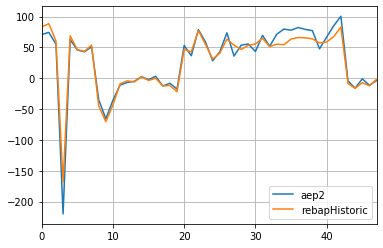

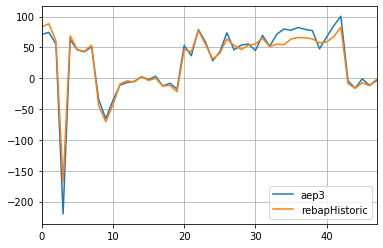

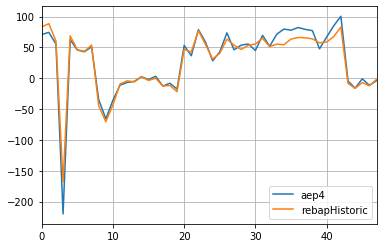

In [62]:
df.plot(y=['aep1','rebapHistoric'], grid=True)
df.plot(y=['aep2','rebapHistoric'], grid=True)
df.plot(y=['aep3','rebapHistoric'], grid=True)
df.plot(y=['aep4','rebapHistoric'], grid=True)

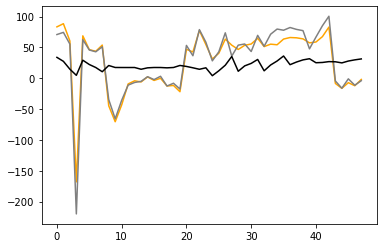

In [63]:
plt.plot(df.rebapHistoric.head(48), color='orange')
plt.plot(df.aep2.values, color='grey')
plt.plot(ID.Preis.head(48).values,color='black')
# plt.plot(NRV.Saldo.head(48).values)

In [64]:
err = df.aep4.values-df.rebapHistoric.values
rms = []
mae = []
from numpy import mean, sqrt, square, arange

for i in range(0,len(err)):
    rms.append(sqrt(mean(square(err[i]))))
    mae.append(mean(np.absolute(err[i])))

print(np.average(rms))
print(np.average(mae))


7.613010656409713
7.613010656409713


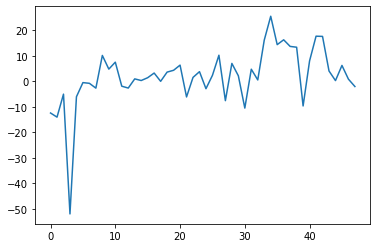

In [65]:
plt.plot(err)
plt.show()